## Imports

In [3]:
import numpy as np
import tensorflow as tf
import os
import cv2
import keras
from keras.preprocessing import image
from keras.layers import Dense,Dropout, Conv2D,MaxPooling2D , Activation, Flatten, Convolution2D
from os.path import isfile, join


## Data augmentation 

In [4]:
train_datagen = image.ImageDataGenerator(rescale = 1./255, shear_range = 0.2,zoom_range = 0.2, 
                                         horizontal_flip = True,  validation_split=0.3,
                                         rotation_range=20)


## Load images to train the cnn

In [5]:
train_set = train_datagen.flow_from_directory('data/Train/',
                                                 target_size = (128, 128),
                                                 batch_size = 25,
                                                 class_mode = 'categorical')

Found 578 images belonging to 3 classes.


## Data augmentation

In [6]:
test_datagen = image.ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, validation_split=0.3, rotation_range=20)

## Load images to test the cnn

In [7]:
test_set = test_datagen.flow_from_directory('data/Test/',
                                                 target_size = (128, 128),
                                                 batch_size = 25,
                                                 class_mode = 'categorical')

Found 342 images belonging to 3 classes.


## Show augmentation

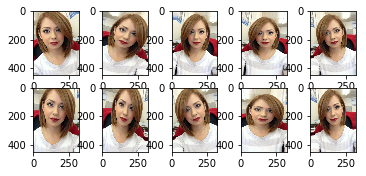

In [8]:
import matplotlib.pyplot as plt

img = image.load_img('data/Test/liso/style.jpg')
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0

for batch in test_datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(450, 322, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()


## Defining the layers of cnn

In [10]:
cnn = tf.keras.models.Sequential()

### First Convolucional layer

In [11]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[128, 128, 3]))

### Pooling 2x2

In [12]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Second Convolucional layer

In [13]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))

### Pooling 2x2

In [14]:
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

### Dropout

In [15]:
cnn.add(tf.keras.layers.Dropout(0.3))

## Flatten

In [17]:
cnn.add(tf.keras.layers.Flatten())

### First Dense Layer

In [18]:
cnn.add(tf.keras.layers.Dense(units=64, activation=tf.keras.layers.LeakyReLU()))

## Dropout

In [19]:
cnn.add(tf.keras.layers.Dropout(0.5))

## Final Dense Layer

In [20]:
cnn.add(tf.keras.layers.Dense(units=32, activation='relu'))

## Dropout

In [21]:
cnn.add(tf.keras.layers.Dropout(0.2))

## Output Layer

In [22]:
cnn.add(tf.keras.layers.Dense(units=3, activation='sigmoid'))

#### Summary

In [23]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 28800)             0

## Training the cnn 

In [7]:
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

cnn.fit(x = train_set, validation_data = test_set, epochs = 26)

Epoch 1/26
24/24 [==============================] - 13s 517ms/step - loss: 1.3997 - accuracy: 0.3491 - val_loss: 1.0926 - val_accuracy: 0.3684
Epoch 2/26
24/24 [==============================] - 12s 498ms/step - loss: 1.0779 - accuracy: 0.4171 - val_loss: 1.0594 - val_accuracy: 0.3977
Epoch 3/26
24/24 [==============================] - 11s 472ms/step - loss: 1.0266 - accuracy: 0.4873 - val_loss: 1.0560 - val_accuracy: 0.3947
Epoch 4/26
24/24 [==============================] - 11s 476ms/step - loss: 0.9976 - accuracy: 0.5047 - val_loss: 0.9603 - val_accuracy: 0.5117
Epoch 5/26
24/24 [==============================] - 12s 488ms/step - loss: 0.8617 - accuracy: 0.6019 - val_loss: 0.9644 - val_accuracy: 0.5058
Epoch 6/26
24/24 [==============================] - 12s 485ms/step - loss: 0.8976 - accuracy: 0.5975 - val_loss: 0.9158 - val_accuracy: 0.5585
Epoch 7/26
24/24 [==============================] - 12s 484ms/step - loss: 0.8397 - accuracy: 0.6360 - val_loss: 0.9157 - val_accuracy: 0.5497

In [8]:
cnn.save('cnn_hair')

INFO:tensorflow:Assets written to: cnn_hair/assets


INFO:tensorflow:Assets written to: cnn_hair/assets


## Function to return the type of hair

In [12]:
def predictCabelo(img):
    test_image = image.load_img(img, target_size = (128, 128))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = cnn.predict(test_image)

    if(result[0][0] == max(result[0])):
        return 'cacheado'
    
    if(result[0][1] == max(result[0])):
        return 'liso'

    if(result[0][2] == max(result[0])):
        return 'ondulado'

## Load `advertising.mp4` to extract frames and generate the predictions

In [13]:
vidcap = cv2.VideoCapture('advertising.mp4')

def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite(f"frames/{count}.jpg", image)
        prediction = predictCabelo(f"frames/{count}.jpg")
        prediction = predictCabelo(f"frames/{count}.jpg")
        cv2.rectangle(image,(150,15),(500,85),(255,255,255), -1)
        cv2.rectangle(image,(150,15),(500,85),(56,142,72), 2)
        cv2.putText(image,prediction,(0 + 200,0 + 0 + 50), cv2.FONT_HERSHEY_COMPLEX,1, (56,142,72), 2, cv2.LINE_AA)  
        cv2.imwrite(f"frames/{count}.jpg", image)
    return hasFrames

sec = 0
frameRate = 0.5
count=1
success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

## Join the frames in `video.avi`

In [14]:
pathIn= './frames/'
pathOut = 'video.avi'
fps = 0.5
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]

files.sort(key = lambda x: x[5:-4])
files.sort()
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]

files.sort(key = lambda x: x[5:-4])
for i in range(len(files)):
    filename=pathIn + files[i]
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    frame_array.append(img)
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

